In [1]:
import pickle 
import yaml
import pandas as pd
from PrepareData import prepare_data


import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import seaborn as sns
from architecture import CLIP
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [2]:
from train_utils import load_model

In [3]:
def make_deterministic(random_seed = 0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

In [4]:
make_deterministic(0)

In [5]:
config = yaml.safe_load(open('./checkpoints/SpecEncoder_and_Decoder_Only/config.yaml', 'r'))



In [6]:
logs = pickle.load(open('./checkpoints/SpecEncoder_and_Decoder_Only/logs.pickle', 'rb'))
for key in logs:
    if "best" in key:
        print(key, logs[key])

best_epoch 70
best_clip_epoch 76
best_recon_epoch 73
best_total_loss 6.029447755505962
best_clip_loss 5.980736640191847
best_recon_loss 0.047414842632509044


In [15]:
model = load_model(config['train']['checkpoint_dir'], type="best_clip")
model.eval()
dataloaders, max_charge, num_species = prepare_data(config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [16]:
from train_utils import decoder_performance
from train_utils import top_scores, decoder_performance, distance_distribution

def clip_performance(config, model, dataloaders, epoch):
    # model.to(device)
    model.eval()
    max_charge = config['data']['max_charge']
    num_species = config['data']['num_species']

    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
            specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids

    test_molembeds = torch.cat(molembeds, 0)
    test_specembeds = torch.cat(specembeds, 0)
    
    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['train'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
                # specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids
    
    train_molembeds = torch.cat(molembeds, 0)
    # train_specembeds = torch.cat(specembeds, 0)
    
    all_molembeds = torch.cat(( test_molembeds, train_molembeds), axis = 0)
    del train_molembeds
    
    tops, scores = top_scores(test_specembeds, all_molembeds)
    del all_molembeds
    
    for k, acc in zip(tops, scores):
        # print("Full Top {} Spec".format(k), acc)
        print({"Full Top {} Spec".format(k): acc})
        

    tops, scores = top_scores(test_specembeds, test_molembeds )
    for k, acc in zip(tops, scores):
        # print("Test Top {} Spec".format(k), acc)
        print({"Test Top {} Spec".format(k): acc})

    # decoder_performance(config, model, dataloaders, epoch)
    plt.clf()
    distance_distribution(test_molembeds, test_specembeds)
    return test_molembeds, test_specembeds

In [17]:
# test_molembeds, test_specembeds = clip_performance(config,model,dataloaders, -1)

In [18]:
from train_utils import Sampler

In [19]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4

class Sampler():
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab
        self.max_len = 40
    def sample(self, embed, greedy_decode=False):
        embed = embed.unsqueeze(0).to(device)
        self.model.eval()
        sample_tensor = torch.zeros((1,self.max_len), dtype=torch.int64).to(device)
        sample_tensor[0,0] = SOS
        with torch.no_grad():
            for i in range(0,self.max_len-1):
                tensor = sample_tensor[:,:i+1]
                logits = self.model.forward(embed, tensor)[:,-1,:]
                probabilities = F.softmax(logits, dim=1)
                sampled_char = torch.multinomial(probabilities,1).item()
                if greedy_decode:
                    sampled_char = torch.argmax(probabilities)
                    
                sample_tensor[0,i+1] = sampled_char
                if sampled_char == EOS:
                    break
            smiles = ""
            chars = self.vocab.from_seq(sample_tensor[0])
            for char in chars:
                if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                    smiles += char
            
        return smiles
  
    def sample_multi(self, n, embed, greedy_decode=False):
        smiles_list = []
        for i in range(n):
            smiles_list.append(self.sample(embed, greedy_decode))
        return smiles_list

In [40]:
def calculate_decoder_accuracy( model, dataloaders, k=1):
    pred_smiles_list = []
    og_smiles_list = []
    count = 0
    n = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):
            data = {k: v.to(device) for k, v in data.items()}
            spec_latents = model.module.forward_spec(data)
            for spec, og in zip(spec_latents, data['smiles'] ):
                ls = sampler.sample_multi(k,spec,greedy_decode=True)
                generated_smiles = []
                for smi in ls:
                    try:
                        generated_smiles.append(Chem.CanonSmiles(smi))
                    except:
                        pass
                og_smile = ""
                chars = model.module.vocab.from_seq(og)
                for char in chars:
                    if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                        og_smile += char
                og_smile = Chem.CanonSmiles(og_smile)
                
                if og_smile in generated_smiles:
                    count += 1
                
                og_smiles_list.append(og_smile)
                pred_smiles_list.append(generated_smiles)
                n += 1
                
            print("No of HitS percentage : ",count/n )

        return count / len(pred_smiles_list), pred_smiles_list, og_smiles_list
    

In [41]:
sampler = Sampler( model.module.smiles_decoder, model.module.vocab)

In [42]:
acc, pred_smiles_list, og_smiles_list = calculate_decoder_accuracy(model, dataloaders, k=1)

1it [00:19, 19.70s/it]

No of HitS percentage :  0.575


2it [00:38, 18.88s/it]

No of HitS percentage :  0.58125


3it [00:56, 18.80s/it]

No of HitS percentage :  0.5925


4it [01:15, 18.84s/it]

No of HitS percentage :  0.595625


5it [01:34, 18.77s/it]

No of HitS percentage :  0.5905


6it [01:52, 18.64s/it]

No of HitS percentage :  0.5870833333333333


7it [02:11, 18.59s/it]

No of HitS percentage :  0.5853571428571429


8it [02:30, 18.69s/it]

No of HitS percentage :  0.583125


9it [02:48, 18.69s/it]

No of HitS percentage :  0.5908333333333333


10it [03:07, 18.77s/it]

No of HitS percentage :  0.59125


11it [03:26, 18.89s/it]

No of HitS percentage :  0.5854545454545454


12it [03:45, 18.83s/it]

No of HitS percentage :  0.583125


13it [04:04, 18.79s/it]

No of HitS percentage :  0.5819230769230769


14it [04:23, 18.81s/it]

No of HitS percentage :  0.5808928571428571


15it [04:42, 18.84s/it]

No of HitS percentage :  0.5795


16it [05:00, 18.81s/it]

No of HitS percentage :  0.58078125


17it [05:19, 18.76s/it]

No of HitS percentage :  0.5789705882352941


18it [05:38, 18.77s/it]

No of HitS percentage :  0.5809722222222222


19it [05:56, 18.76s/it]

No of HitS percentage :  0.5805263157894737


20it [06:15, 18.73s/it]

No of HitS percentage :  0.581


21it [06:34, 18.81s/it]

No of HitS percentage :  0.5827380952380953


22it [06:53, 18.78s/it]

No of HitS percentage :  0.5811363636363637


23it [07:11, 18.69s/it]

No of HitS percentage :  0.5832608695652174


24it [07:30, 18.69s/it]

No of HitS percentage :  0.5834375


25it [07:48, 18.64s/it]

No of HitS percentage :  0.5837


26it [08:07, 18.63s/it]

No of HitS percentage :  0.5838461538461538


27it [08:26, 18.63s/it]

No of HitS percentage :  0.5842592592592593


28it [08:44, 18.51s/it]

No of HitS percentage :  0.585


29it [09:03, 18.55s/it]

No of HitS percentage :  0.5839655172413794


30it [09:21, 18.58s/it]

No of HitS percentage :  0.5834166666666667


31it [09:35, 17.15s/it]

No of HitS percentage :  0.5841471354166666


31it [09:35, 18.58s/it]


In [33]:
acc, pred_smiles_list, og_smiles_list = calculate_decoder_accuracy(model, dataloaders, k=3)

1it [00:53, 53.71s/it]

No of HitS percentage :  0.59


2it [01:46, 53.38s/it]

No of HitS percentage :  0.5675


3it [02:40, 53.36s/it]

No of HitS percentage :  0.5691666666666667


4it [03:32, 53.12s/it]

No of HitS percentage :  0.56875


5it [04:25, 53.07s/it]

No of HitS percentage :  0.57


6it [05:18, 52.91s/it]

No of HitS percentage :  0.5691666666666667


7it [06:11, 52.95s/it]

No of HitS percentage :  0.57


8it [07:03, 52.79s/it]

No of HitS percentage :  0.5684375


9it [07:56, 52.70s/it]

No of HitS percentage :  0.5675


10it [08:49, 52.67s/it]

No of HitS percentage :  0.56525


11it [09:42, 52.86s/it]

No of HitS percentage :  0.5609090909090909


12it [10:35, 52.90s/it]

No of HitS percentage :  0.5566666666666666


13it [11:28, 53.02s/it]

No of HitS percentage :  0.5540384615384616


14it [12:21, 52.82s/it]

No of HitS percentage :  0.5564285714285714


15it [13:14, 52.93s/it]

No of HitS percentage :  0.559


16it [14:07, 52.99s/it]

No of HitS percentage :  0.55765625


17it [15:00, 52.92s/it]

No of HitS percentage :  0.5577941176470588


18it [15:53, 53.15s/it]

No of HitS percentage :  0.5595833333333333


19it [16:46, 53.11s/it]

No of HitS percentage :  0.5615789473684211


20it [17:39, 53.13s/it]

No of HitS percentage :  0.562625


21it [18:33, 53.18s/it]

No of HitS percentage :  0.5633333333333334


22it [19:26, 53.31s/it]

No of HitS percentage :  0.5640909090909091


23it [20:20, 53.33s/it]

No of HitS percentage :  0.5648913043478261


24it [21:13, 53.20s/it]

No of HitS percentage :  0.5642708333333334


25it [22:06, 53.12s/it]

No of HitS percentage :  0.5648


26it [22:59, 53.07s/it]

No of HitS percentage :  0.5636538461538462


27it [23:52, 53.26s/it]

No of HitS percentage :  0.5625925925925926


28it [24:45, 53.23s/it]

No of HitS percentage :  0.5642857142857143


29it [25:38, 53.14s/it]

No of HitS percentage :  0.5652586206896552


30it [26:32, 53.42s/it]

No of HitS percentage :  0.5656666666666667


31it [27:27, 53.63s/it]

No of HitS percentage :  0.5644354838709678


32it [28:20, 53.59s/it]

No of HitS percentage :  0.564375


33it [29:13, 53.50s/it]

No of HitS percentage :  0.5647727272727273


34it [30:07, 53.41s/it]

No of HitS percentage :  0.5652205882352941


35it [31:03, 54.37s/it]

No of HitS percentage :  0.5656428571428571


36it [31:59, 54.68s/it]

No of HitS percentage :  0.56625


37it [32:52, 54.20s/it]

No of HitS percentage :  0.5654729729729729


38it [33:46, 54.21s/it]

No of HitS percentage :  0.5660526315789474


39it [34:39, 53.81s/it]

No of HitS percentage :  0.5665384615384615


40it [35:32, 53.75s/it]

No of HitS percentage :  0.566875


40it [36:05, 54.14s/it]


KeyboardInterrupt: 

In [ ]:
acc, pred_smiles_list, og_smiles_list = calculate_decoder_accuracy(model, dataloaders, k=5)

20it [16:00, 48.01s/it]


KeyboardInterrupt: 

In [ ]:
acc, pred_smiles_list, og_smiles_list = calculate_decoder_accuracy(model, dataloaders, k=10)

31it [05:11, 10.06s/it]

No of Hits :  4598


In [42]:
class Sampler():
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab
        self.max_len = 40
    def sample(self, embed, greedy_decode=False):
        embed = embed.unsqueeze(0).to(device)
        self.model.eval()
        sample_tensor = torch.zeros((1,self.max_len), dtype=torch.int64).to(device)
        sample_tensor[0,0] = SOS
        with torch.no_grad():
            for i in range(0,self.max_len-1):
                tensor = sample_tensor[:,:i+1]
                logits = self.model.forward(embed, tensor)[:,-1,:]
                probabilities = F.softmax(logits, dim=1)
                sampled_char = torch.multinomial(probabilities,1).item()
                if greedy_decode:
                    sampled_char = torch.argmax(probabilities)
                    
                sample_tensor[0,i+1] = sampled_char
                if sampled_char == EOS:
                    break
            smiles = ""
            chars = self.vocab.from_seq(sample_tensor[0])
            for char in chars:
                if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                    smiles += char
            
        return smiles
  
    def sample_multi(self, n, embed, greedy_decode=False):
        smiles_list = []
        for i in range(n):
            smiles_list.append(self.sample(embed, greedy_decode))
        return smiles_list

In [43]:
acc, pred_smiles_list, og_smiles_list = calculate_decoder_accuracy(model, dataloaders, k=1)

2it [00:22, 11.25s/it]


KeyboardInterrupt: 

In [ ]:
acc, pred_smiles_list, og_smiles_list = calculate_decoder_accuracy(model, dataloaders, k=3)

In [ ]:
parsed_mols = np.array([Chem.MolFromSmiles(s) for s in smiles_list])
print("Percentage valid", (parsed_mols != None).sum()/len(parsed_mols))

Percentage valid 0.9855143229166666


In [ ]:
count = 0
for og_smile, pred_smile in zip(og_smiles_list, smiles_list):
    og = Chem.CanonSmiles(og_smile)
    try:
        pred= Chem.CanonSmiles(pred_smile)
        if og == pred:
            count += 1
    except:
        pass
print(count / len(og_smiles_list))

0.3761393229166667


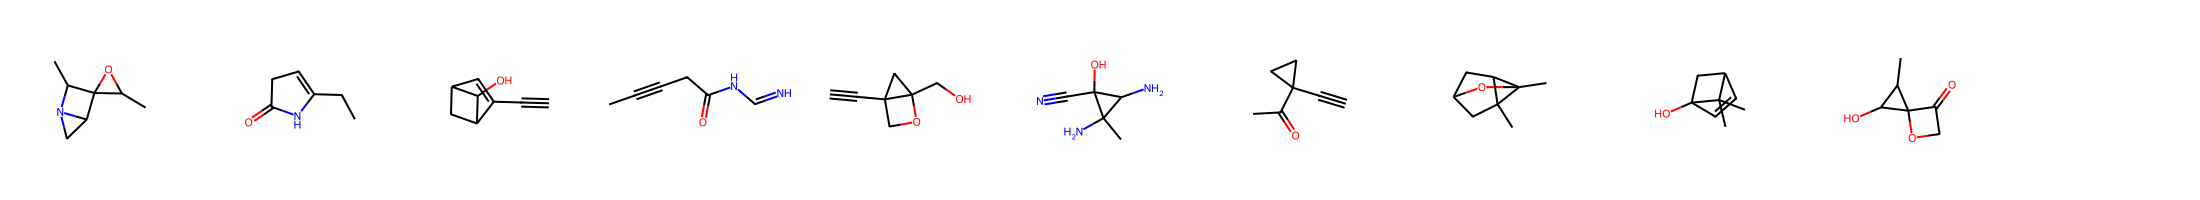

In [ ]:
Draw.MolsToGridImage(np.array([Chem.MolFromSmiles(smi) for smi in og_smiles_list])[5000:5010], molsPerRow=11, returnPNG=False)

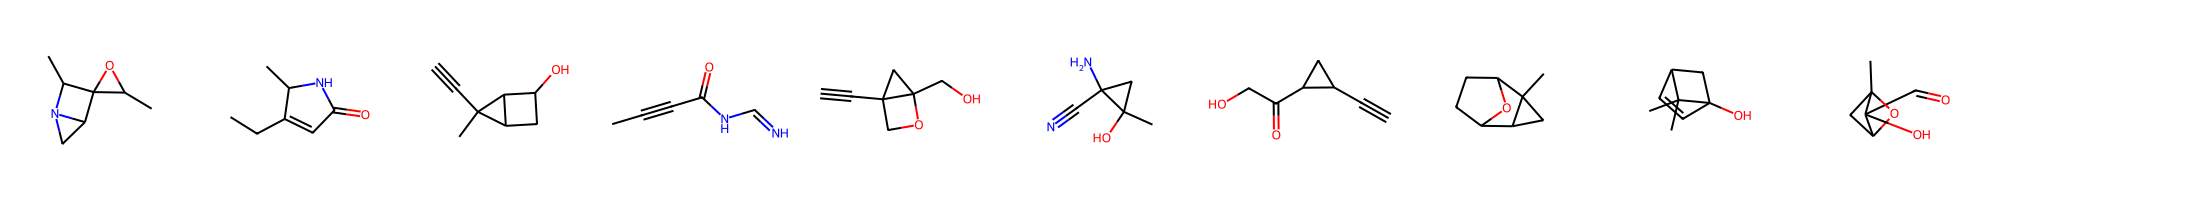

In [ ]:
Draw.MolsToGridImage(np.array([Chem.MolFromSmiles(smi) for smi in smiles_list])[5000:5010], molsPerRow=11, returnPNG=False)

In [ ]:
len(og_smiles)

14